# Restricting a dolfin Function to a submesh

**Author**: Maximilian Albert

**Date**: Nov 2013

**Purpose**: Illustrate how to restrict a `dolfin.Function` to a submesh using different approaches. This also illustrates how to extract the boundary mesh of a full 3D mesh and how to map vertices from the submesh back to the parent mesh.

---

In this notebook we explore how to restrict a function to a submesh. In this case we use the magnetisation of a small sample simulation where the mesh is a nanodisk, and we'd like to extract the magnetisation in the top layer of the disk only.

In [1]:
import dolfin as df
import finmag
import numpy as np
from finmag.util.meshes import plot_mesh_with_paraview
from finmag.util.visualization import render_paraview_scene

[2014-06-09 13:36:17] INFO: Finmag logging output will be appended to file: '/home/albert/.finmag/global.log'
[2014-06-09 13:36:17] DEBUG: Building modules in 'native'...
[2014-06-09 13:36:18] DEBUG: FinMag          5013:46a56357a0fe82a9fd426ca437f6aca06e2c8160
[2014-06-09 13:36:18] DEBUG: Dolfin          1.4.0                Matplotlib      1.3.0               
[2014-06-09 13:36:18] DEBUG: Numpy           1.8.0                Scipy           0.12.0              
[2014-06-09 13:36:18] DEBUG: IPython         2.1.0                Python          2.7.5+              
[2014-06-09 13:36:18] DEBUG: Paraview        4.0.1-1              Sundials        2.5.0               
[2014-06-09 13:36:18] DEBUG: Boost-Python    <unknown>            Linux           Linux Mint 16 Petra 
[2014-06-09 13:36:18] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.


For our simulation, we use Finmag's `disk` example.

In [2]:
sim = finmag.example.normal_modes.disk()

[2014-06-09 13:36:19] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/normal_modes_nanodisk.log' (any old content will be overwritten).
[2014-06-09 13:36:19] DEBUG: Creating DataWriter for file 'normal_modes_nanodisk.ndt'
[2014-06-09 13:36:19] INFO: Creating Sim object 'normal_modes_nanodisk' (rank=0/1).
[2014-06-09 13:36:19] INFO: <Mesh of topological dimension 3 (tetrahedra) with 333 vertices and 1016 cells, ordered>
[2014-06-09 13:36:19] DEBUG: Creating LLG object.
[2014-06-09 13:36:19] DEBUG: Creating Exchange object with method box-matrix-petsc, in Jacobian.
[2014-06-09 13:36:19] DEBUG: Adding interaction Exchange to simulation.
[2014-06-09 13:36:19] DEBUG: Adding interaction Zeeman to simulation.
[2014-06-09 13:36:19] DEBUG: Creating Demag object with solver 'FK'.
[2014-06-09 13:36:19] DEBUG: Adding interaction Demag to simulation.
[2014-06-09 13:36:19] DEBUG: Successfully created simulation 'normal_modes_nanodisk'
[20

We need the magnetisation as a `dolfin.Function` (*not* as a numpy array), so we extract it here for further use below.

In [3]:
m = sim.get_field_as_dolfin_function('m')

In [4]:
mesh = sim.mesh
mesh_coords = mesh.coordinates()

In [5]:
#V = df.FunctionSpace(mesh, 'CG', 1)
#f = df.Function(V)
#f.vector()[:] = arange(len(f.vector()))

## Extracting the boundary mesh

First we extract the boundary mesh, which is a 2D mesh consisting of all the surfaces. This includes the top surface, but also the bottom and the sides.

In [6]:
boundary_mesh = df.BoundaryMesh(mesh, 'exterior')
print "Number of boundary nodes: {}".format(boundary_mesh.num_vertices())

Number of boundary nodes: 284


The entity map of the boundary mesh contains the mapping of the vertices into the big mesh.

In [7]:
em = boundary_mesh.entity_map(0)
entity_map = em.array()

In [8]:
print entity_map

[150 168 183 129 130 155 162 163 175  54  55 212  77 138 139 207 208 235
  17  84 105   5   6 118  99  43  83 103 117 170 174 185  78  79 133 134
 158  19  20  96  39 199 200 149  11 122 123 217 242 243 195 196 198 256
 257 274  66 221 222 116 146 178 188 192  52 246  48  80 101  98  32  33
 140  92 127 128 223 247  44  45 204  82  24  25  88 164 205 233 234 224
 248 191  72  87 107  16 245  46 206  31  91 111 214 215 240  30 110  58
 260 266  35  93 113 263 273 277  36  94 229 251 252 143 165 167  62 112
 267 152 153 171 262 241 213 119 244 264 265 271 275  81 102  65  63  29
 137 225 142  61 218 145 151 219  18  42 104   9  10 121   7 120  23  64
  85  86  75  22 106 157 177 255 259 270 211 237 238 147 169  56  76  97
  13 253 124 125  12  90 269 279 282 258  27 135 136 159 160   3 132 189
  38  60  37  53  26  89 108 182 187  15 126  40  41 201 197 172 190 193
  59 216 148  14  21 131 220  49  50 100 239 278 280 283  51 209 236  71
 226 141  34 249  70 203 268 202   1 114 115 161 14

## Extracting the top surface of the mesh

Now we extract the top surface as a sub-mesh of the boundary mesh. We do this by creating a MeshFunction which marks all triangles in the boundary mesh that belong to the top surface, and then extract the SubMesh through that MeshFunction.

In [9]:
z_max = max(mesh_coords[:, 2])

class Top(df.SubDomain):
    def inside(self, pt, on_boundary):
        x, y, z = pt
        return (z >= z_max - df.DOLFIN_EPS) and (z <= z_max + df.DOLFIN_EPS)

In [10]:
sub_domains = df.MeshFunction('size_t', boundary_mesh, 2)
sub_domains.set_all(0)

In [11]:
top = Top()
top.mark(sub_domains, 1)

In [12]:
top_layer = df.SubMesh(boundary_mesh, sub_domains, 1)
#print top_layer.coordinates()

Here is a plot of the top surface mesh. As expected, it is a 2D mesh and seems to have the right size.

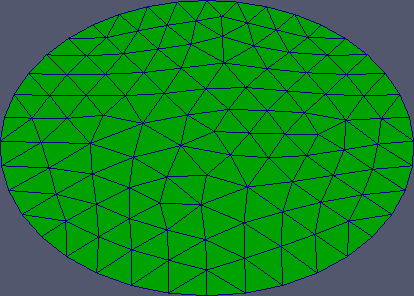

In [13]:
plot_mesh_with_paraview(top_layer)

We can get the vertex association between the top_layer mesh and the boundary mesh as follows. (This syntax is quite non-obvious; I found the code snippet in this answer: [1]. Perhaps it's worth prodding the FEniCS developers to make this more discoverable.)

[1] http://fenicsproject.org/qa/185/entity-mapping-between-a-submesh-and-the-parent-mesh

In [14]:
parent_vertex_indices = top_layer.data().array('parent_vertex_indices', 0)

In [15]:
print parent_vertex_indices
print len(parent_vertex_indices)

[  9  10  11  15  16  17  40  41  42  47  48  49  53  54  55  56  57  58
  65  76  77  78  79  80  86  87  88  89  90  96  97  98 102 103 104 107
 108 109 113 114 115 118 119 120 126 130 131 132 134 135 136 137 138 145
 124 147 148 142 151 161 169 170 171 172 173 174 181 186 187 188 189 164
 198 209 210 211 216 217 222 223 224 226 227 228 229 141 231 232 233 234
 237 238  25 239 240  66 241 230 177 248 251 252 255 264 265 266 267 201
 270 271 272 273 274 153 277 199 279 280 281  92 282 254  64]
123


Let's see whether these really correspond to the vertices we expect.

In [16]:
boundary_coords = boundary_mesh.coordinates()
top_layer_coords_1 = np.array([boundary_coords[i] for i in parent_vertex_indices])

Let's double-check whether these still give the right coordinates when we embed the top_layer back into the original mesh.

In [17]:
mesh_coords = mesh.coordinates()
top_layer_coords_2 = np.array([mesh_coords[entity_map[i]] for i in parent_vertex_indices])

In [18]:
print "The two mappings give the same result: {}".format(np.allclose(top_layer_coords_1, top_layer_coords_2))

The two mappings give the same result: True


Excellent, so this works!

## Restricting a function to the top layer

### Using `df.Restriction`

One way of restricting the magnetisation to the top layer is by using the newly-introduced `dolfin.Restriction`.

In [19]:
restriction = df.Restriction(sub_domains, 1)
V_restr  = df.VectorFunctionSpace(restriction, 'CG', 1)
m_restr = df.interpolate(m, V_restr)

Let's save the restricted function to a file and visualise it.

In [20]:
f = df.File('m_restr.pvd')
m_restr.rename('m', 'magnetisation')
f << m_restr

If we look closely, we see in the following picture that `m_restr` has actually stored the whole mesh, but only has degrees of freedom at vertices corresponding to the top layer.

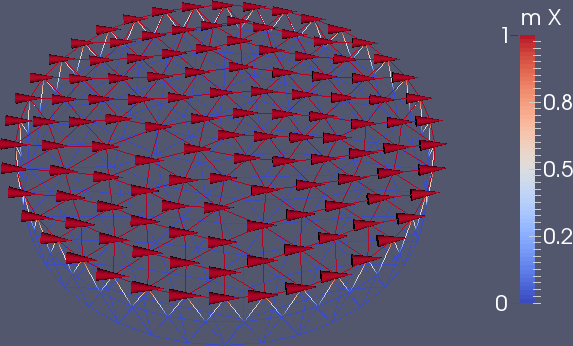

In [22]:
render_paraview_scene('m_restr.pvd', representation='Wireframe')

It is interesting to note that `m_restr` is *not* a function defined on the entire mesh (which simply has value zero outside the top layer). Instead, it actually only has degrees of freedoms in the top layer:

In [23]:
print "Shape of m_restr: {}".format(m_restr.vector().array().reshape(3, -1).shape)
print "Number of mesh vertices in the top layer: {}".format(top_layer.num_vertices())
print "Number of mesh vertices in the entire mesh: {}".format(mesh.num_vertices())

Shape of m_restr: (3, 123)
Number of mesh vertices in the top layer: 123
Number of mesh vertices in the entire mesh: 333


### Interpolating on the smaller function space

An alternative of the above approach is not to use a `dolfin.Restriction`, but instead directly interpolate the "large" function to a function space that is only defined on the top layer.

In [24]:
V_toplayer  = df.VectorFunctionSpace(top_layer, 'CG', 1, dim=3)

In [25]:
m_toplayer = df.interpolate(sim.llg._m, V_toplayer)

In [26]:
f = df.File('m_toplayer.pvd')
m_toplayer.rename('m', 'magnetisation')
f << m_toplayer

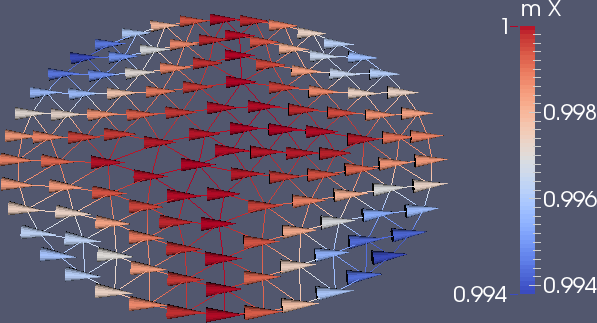

In [27]:
render_paraview_scene('m_toplayer.pvd', representation='Wireframe')

In contrast to the approach with `df.Restriction`, we now get a function that only "knows" about the part of the mesh in the top layer.

### Manually interpolating the function values on the submesh

Unfortunately, sometimes using `df.interpolate` to interpolate a function on a submesh leads to a crash in dolfin (probably due to numerical inaccuracies). Here is an approach to manually interpolate the function on the mesh nodes in the top layer, simply by copying the function values from the whole function vector into a smaller vector.

**Warning:** I presume that this approach does not work if dof reordering in dolfin is enabled (in particular, it wouldn't work in parallel). With dof reordering, we likely need to use the dof mapping that dolfin provides (but I don't know how to do that properly). Also, one would think that there must be a function in dolfin already which performs this functionality without using `df.interpolate`. Probably worth prodding the FEniCS developers about this.

First we get the numpy array corresponding to the magnetisation.

In [28]:
m_array = sim.llg._m.vector().array().reshape(3, -1)
print m_array.shape

(3, 333)


Next we define the numpy array for the magnetisation in the top layer, by extracting the correct vertex values.

In [29]:
m_array_surface = m_array[:, [entity_map[i] for i in parent_vertex_indices]]

Indeed, this array has the correct shape.

In [30]:
m_array_surface.shape

(3, 123)

If we create a `dolfin.Function` from this array and plot it we can see that it indeed seems to have extracted the correct values.

In [31]:
m_surface_fun = df.Function(V_toplayer)
_ = m_surface_fun.vector().set_local(m_array_surface.ravel())

In [32]:
f = df.File('m_surface_fun.pvd')
m_surface_fun.rename('m', 'magnetisation')
f << m_surface_fun

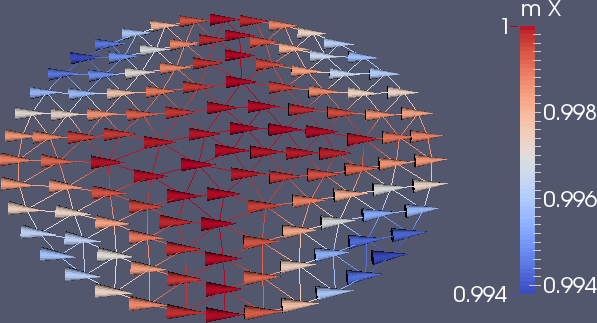

In [34]:
render_paraview_scene('m_surface_fun.pvd', representation='Wireframe')